In [1]:
# cGAN
# 출처 : http://i-systems.github.io/HSE545/iAI/DL/topics/09_GAN/02_CGAN.html

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# cGAN이 GAN과 가장 큰 차이점은 condition -> label(y)가 들어간다는 것
# condition을 주기 위해 n_label 변수를 설정해준다.

n_D_input = 28*28
n_D_hidden = 256
n_D_output = 1

n_G_input = 128
n_G_hidden = 256
n_G_output = 28*28

n_label = 10 # one-hot-encoding

In [4]:
# weights 쓰이는 변수들은 랜덤으로 숫자를 만들고, biases 들은 0으로 초기화 함

weights = {
    'G1' : tf.Variable(tf.random_normal([n_G_input + n_label, n_G_hidden], stddev = 0.01)),
    'G2' : tf.Variable(tf.random_normal([n_G_hidden, n_G_output], stddev = 0.01)),
    'D1' : tf.Variable(tf.random_normal([n_D_input + n_label, n_D_hidden], stddev = 0.01)),
    'D2' : tf.Variable(tf.random_normal([n_D_hidden, n_D_output], stddev = 0.01))
}

biases = {   
    'G1' : tf.Variable(tf.zeros([n_G_hidden])),
    'G2' : tf.Variable(tf.zeros([n_G_output])),
    'D1' : tf.Variable(tf.zeros([n_D_hidden])),
    'D2' : tf.Variable(tf.zeros([n_D_output]))
}

# z : z_noise  x : input image  c : condition(label)

z = tf.placeholder(tf.float32, [None, n_G_input])
x = tf.placeholder(tf.float32, [None, n_D_input])
c = tf.placeholder(tf.float32, [None, n_label])

In [5]:
# 생성기(Generator)의 신경망 구성
# hidden layer에 G_input과 함께 label(condition)이 들어간다

def generator(G_input, label, weights, biases):
    hidden = tf.nn.relu(tf.matmul(tf.concat([G_input, label], 1), weights['G1']) + biases['G1']) # tf.concat : axis 1을 기준으로 G_input과 label을 이어 붙임   
    output = tf.nn.sigmoid(tf.matmul(hidden, weights['G2']) + biases['G2'])
    return output

In [6]:
# 판별기(Discriminator)의 신경망 구성
# 마찬가지로 input에 label이 함께 들어간다

def discriminator(D_input, label, weights, biases):
    hidden = tf.nn.relu(tf.matmul(tf.concat([D_input, label], 1), weights['D1']) + biases['D1'])
    output = tf.nn.sigmoid(tf.matmul(hidden, weights['D2']) + biases['D2'])
    return output

In [7]:
# 노이즈(z) 생성

def make_noise(n_batch, n_G_input):
    return np.random.normal(size = (n_batch, n_G_input))

In [8]:
G_output = generator(z, c, weights, biases)
D_fake = discriminator(G_output, c, weights, biases)
D_real = discriminator(x, c, weights, biases)

# GAN의 loss function과 동일 (여기에서는 loss function에서 - 해줌)
D_loss = tf.reduce_mean(-tf.log(D_real)-tf.log(1 - D_fake))
G_loss = tf.reduce_mean(-tf.log(D_fake))

# optimizer에 넣기 위해 list로 만들어줌
D_var_list = [weights['D1'], biases['D1'], weights['D2'], biases['D2']]
G_var_list = [weights['G1'], biases['G1'], weights['G2'], biases['G2']]

LR = 0.0002 # learning rate

# 각각 AdamOptimizer로 loss를 minimize하는 변수를 학습한다
D_optm = tf.train.AdamOptimizer(LR).minimize(D_loss, var_list = D_var_list)
G_optm = tf.train.AdamOptimizer(LR).minimize(G_loss, var_list = G_var_list)

In [9]:
n_batch = 100  # batch size
n_iter = 50000 # epoch
n_prt = 5000   # 이미지를 5000번째마다 프린트하기 위해 설정

Epoch: 0000 D_loss: 1.357 G_loss: 0.7282


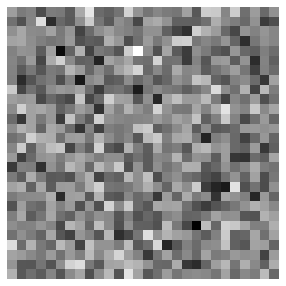

Epoch: 5000 D_loss: 0.1018 G_loss: 3.832


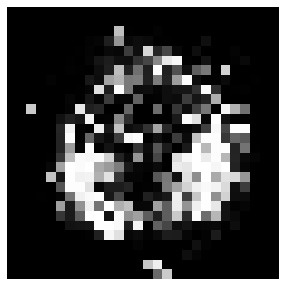

Epoch: 10000 D_loss: 0.3568 G_loss: 2.482


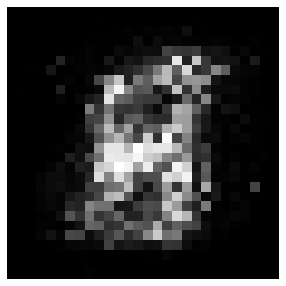

Epoch: 15000 D_loss: 0.7368 G_loss: 2.093


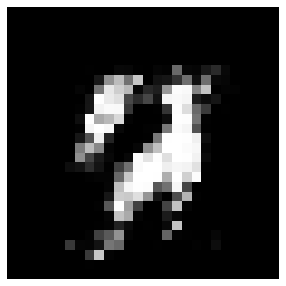

Epoch: 20000 D_loss: 0.5106 G_loss: 2.129


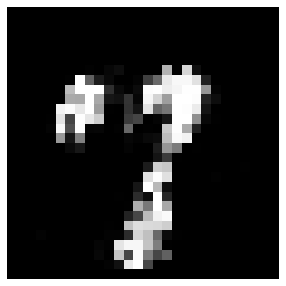

Epoch: 25000 D_loss: 0.571 G_loss: 2.158


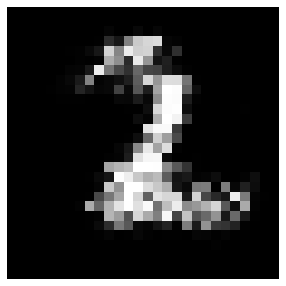

Epoch: 30000 D_loss: 0.584 G_loss: 1.851


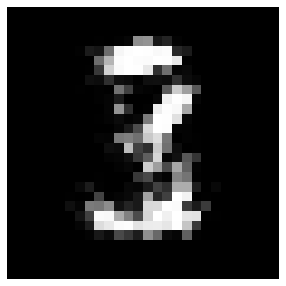

Epoch: 35000 D_loss: 0.8269 G_loss: 1.706


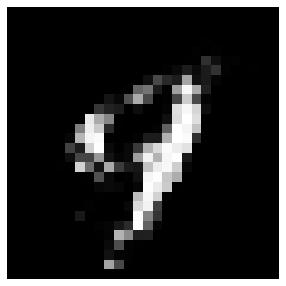

Epoch: 40000 D_loss: 0.7609 G_loss: 1.582


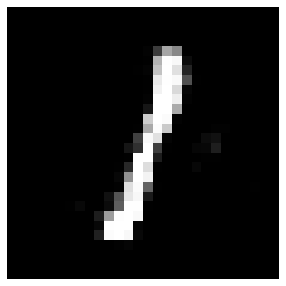

Epoch: 45000 D_loss: 0.6206 G_loss: 1.962


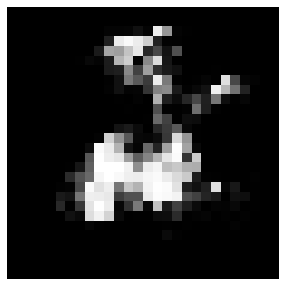

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

D_loss_record = []
G_loss_record = []
for epoch in range(n_iter):
    train_x, train_y = mnist.train.next_batch(n_batch) # batch size만큼 이미지와 label를 갖고온다
    noise = make_noise(n_batch, n_G_input) # Generator에 input으로 들어가는 노이즈 생성

    # discriminator와 generator가 각각 돌아가면서 학습한다
    sess.run(D_optm, feed_dict = {x: train_x, z: noise, c: train_y})
    sess.run(G_optm, feed_dict = {z: noise, c: train_y})

    # 5000번째 마다 이미지 프린트
    if epoch % n_prt == 0:
        D_loss_val = sess.run(D_loss, feed_dict = {x: train_x, z: noise, c: train_y})
        G_loss_val = sess.run(G_loss, feed_dict = {z: noise, c: train_y})
        D_loss_record.append(D_loss_val)
        G_loss_record.append(G_loss_val)
        
        print('Epoch:', '%04d' % epoch, 'D_loss: {:.4}'.format(D_loss_val), 'G_loss: {:.4}'.format(G_loss_val))

        plt.figure(figsize = (5,5))
        noise = make_noise(1, n_G_input)
        _, train_y = mnist.train.next_batch(1)
        G_img = sess.run(G_output, feed_dict = {z: noise, c: train_y})   
        plt.imshow(G_img.reshape(28,28), 'gray')
        plt.axis('off')
        plt.show()